This report contains comparison between tower data and eeflux data tackling Ameriflux, Euroflux with
EEflux data.
<br>
The data is corrected using the bowens method manually i.e no library applied
<br>
EEflux ETo and EEflux ETr for Ameriflux is brought from the Climate Engine website
<br>
EEflux ETo for Euroflux is brought from the EEflux Engine website
<br>

ETo and ETr for Tower data (i.e Ameriflux and Euroflux) is computed on the daily data using refET library
<br>

EToF is computed for both using LE(mm) corrected / ETo
<br>
ETrF is computed for both using LE(mm) corrected / ETr

Joint data for all sites is available in here:
https://console.cloud.google.com/storage/browser/_details/agriculture-sara/Data%20sets/Ameriflux%20and%20Euroflux%20-%20EEflux/Correction%20-%20Manual%20Bowens%20ETo%20+%20ETr/All_Joint.csv?project=wired-ripsaw-240811

## Libraries

In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import refet
import pvlib
import warnings
warnings.filterwarnings('ignore')

base_path = "/Users/saraawad/Desktop/Datasets/Google/"

## Helper Methods

In [2]:
class Helpers:
    def __init__(self):
        print("Helper")
        
    def convert_missing_values_nan(df):
        '''This function will convert -9999 to NaN'''
        df = df.replace(-9999.000000, np.NaN)
        return df

    def drop_nan_columns(df):
        '''Drops the columns having all theirs rows as Nans'''
        columns_to_exclude = ["Date", "Day", "Year", "Month", "Timestamp start"
                              , "Time", "TIMESTAMP", "Tier", "TIMESTAMP_START", "TIMESTAMP_END", "Day Status"]
        columns = df.columns
        for i in range(len(columns)):
            col = columns[i]
            if col in columns_to_exclude:
                continue
            nan_sum_col = df[col].isnull().sum()
            if nan_sum_col == len(df):
                df.drop(col, axis=1, inplace=True)
        return df
    
    def drop_nans_rows(df):
        '''This function will drop the rows having NaNs'''
        print("Before removing missing values:")
        print("number of rows:", df.shape[0], "\nnumber of columns:", df.shape[1])
        df = df.dropna(how='any')
        print("After removing missing values:")
        print("number of rows:", df.shape[0], "\nnumber of columns:", df.shape[1])
        return df
        
    def get_all_matching_columns(df, keyword):
        return df.filter(like=keyword).columns

    def generate_lags(df, column, lags_count): 
        for i in range(lags_count):
            lag_name = column + "-" + str(i + 1)
            df[lag_name] = df[column].shift(i + 1)
        return df

    def add_LE_conversion_rate(df, col):
        conversion_rate = 28.94
        new_col = col + "(mm)"
        df[new_col] = df[col] / conversion_rate
        return df

    def read_sites_data():
        file_path = os.path.join(base_path, "filtered_sites_all.xlsx")
        df = pd.read_excel(file_path)
        df.head()
        return df

    def export_data(df, file_path):
        export_path = os.path.join(base_path, file_path + ".csv")
        export_csv = df.to_csv(export_path, index=None, header=True)

    def load_data(file_path):
        df = pd.read_csv(file_path + ".csv", delimiter=',')
        return df
    
    def list_to_df(list_to_convert):
        '''This function will convert the provided list into a dataframe'''
        df = pd.concat(list_to_convert, sort=True)
        return df
    
    def get_files_directory(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
        listOfFile = os.listdir(dirName)
        allFiles = list()
        # Iterate over all the entries
        for entry in listOfFile:
            # Create full path
            if entry.endswith(".xlsx") or entry.endswith(".icloud") or entry.endswith(".DS_Store"):
                continue
            fullPath = os.path.join(dirName, entry)
            # If entry is a directory then get the list of files in this directory 
            if os.path.isdir(fullPath):
                allFiles = allFiles + Helpers.get_files_directory(fullPath)
            else:
                allFiles.append(fullPath)

        return allFiles

    def concat_dataframe_from_files(files, skipRowsNum, split_num, hasSiteIDAlready):
        values = []
        for i in range(len(files)):
            file_path = files[i]
            head, file_name = os.path.split(file_path)
            #Get only the sheets having the variables
            if file_name.endswith(".csv"):
                df = pd.read_csv(file_path, delimiter=',', skiprows=skipRowsNum)
                site_id = file_name.split("_")[split_num]
                if hasSiteIDAlready == False:
                    df["Site Id"] = site_id
                values.append(df)
        return Helpers.list_to_df(values)   
    
    def generate_dataframe_from_files(dirName, skipRowsNum = 0, split_num = 0, hasSiteIDAlready = False):
        files = Helpers.get_files_directory(dirName)
        df = Helpers.concat_dataframe_from_files(files, skipRowsNum, split_num, hasSiteIDAlready)
        return df
       

## Plot Tower Versus EEflux Metrics with Errors

In [3]:
class ErrorGraph:
    def __init__(self, path,
                 tower_column,
                 eeflux_column,
                 extra_column,
                 export_path,
                 isET = True):
        print("ErrorGraph Initializer")
        self.path = path
        self.eeflux_column = eeflux_column
        self.tower_column = tower_column
        self.extra_column = extra_column
        self.export_path = export_path
        self.isET = isET
          
    def read_data(self):
        file_name = os.path.join(base_path, self.path)
        df = pd.read_csv(file_name, index_col=None, header=0)
        return df

    def get_error_metrics(self, y_true, y_predicted):
        r2_Score = r2_score(y_true, y_predicted)
        rmse_score = np.sqrt(mean_squared_error(y_true, y_predicted))
        mse_score = mean_squared_error(y_true, y_predicted)
        mae_score = mean_absolute_error(y_true, y_predicted)

        def mean_absolute_percentage_error(y_true, y_pred):
            y_true, y_pred = np.array(y_true), np.array(y_pred)
            return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        mape_score = mean_absolute_percentage_error(y_true, y_predicted)
        num = 2
        return (round(r2_Score, num), round(rmse_score, num), round(mse_score, num), 
                round(mae_score, num), round(mape_score, num))


    def generate_errors(self, df, first_col, second_col):
        df = df.replace(to_replace = np.nan, value =0) 
        errors = self.get_error_metrics(df[first_col], df[second_col])
        return errors
    
    def plot_metric(self, df, site_id, first_column, second_column, extra_column, path_to_save):
        fig, ax = plt.subplots(figsize=(20, 22))
        fig.subplots_adjust(bottom=0.15, left=0.2)
        plt.subplot(121)
        title1 = site_id + ": comparison between " + first_column + " and " + second_column
        if np.all(df[first_column].isnull()):
            return
        else:
            self.plot_sub(df, first_column, second_column, title1)

            plt.xticks(rotation=90)
            ax.legend()
            plt.show()
            full_path = os.path.join(base_path, path_to_save)
    #         plt.savefig(full_path + site_id + "_et.png")
            plt.close(fig)

    def plot_sub(self, df, first_column, second_column, title):
        ax = sns.regplot(x=first_column, y=second_column, data=df, fit_reg=False)
        lims = [
            np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
            np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
            ]

        # now plot both limits against eachother
        ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
        ax.set_aspect('equal')
        ax.set_xlim(lims)
        ax.set_ylim(lims)
       
        plt.title(title, fontsize=13)
        
        
    def prepare_data(self, df):
        unique_sites = df["Site Id"].unique()
        unique_sites

        r2_list, rmse_list, mse_list, mae_list, mape_list, true_average_list = [], [], [], [], [], []
        for i in range(len(unique_sites)):
            site_id = unique_sites[i]
            df_site = df[df["Site Id"] == site_id]
            (r2, rmse, mse, mae, mape) = self.generate_errors(df_site, self.tower_column, self.eeflux_column)
            r2_list.append(r2)
            rmse_list.append(rmse)
            mse_list.append(mse)
            mae_list.append(mae)
            mape_list.append(mape)
            true_average = df_site[self.tower_column].mean()
            true_average_list.append(true_average)
            df_site['Date'] = pd.to_datetime(df_site["Date"])
            df_site.sort_values(by="Date", inplace=True, ascending=True)
            #Plot the output feature
            if np.all(df_site[self.tower_column].isnull()):
                continue
            if len(df_site) > 0:
                self.plot_metric(df_site,
                                 site_id,
                                 self.tower_column,
                                 self.eeflux_column,
                                 self.extra_column, 
                                 self.export_path)

        df_errors = pd.DataFrame({"Site Id": unique_sites,
                                  "True Value": self.tower_column,
                                  "Predicted Value": self.eeflux_column,
                                  "True Average Value": true_average_list,
                                  "R2": r2_list,
                                  "RMSE": rmse_list, 
                                  "MSE": rmse_list,
                                  "MAE": mae_list, 
                                  "MAPE": mape_list})
        print(df_errors)
        errors_path = self.export_path + "Errors_ET"
        Helpers.export_data(df_errors, errors_path)

## Plot LE calibrated corrected versus EEflux ET

ErrorGraph Initializer


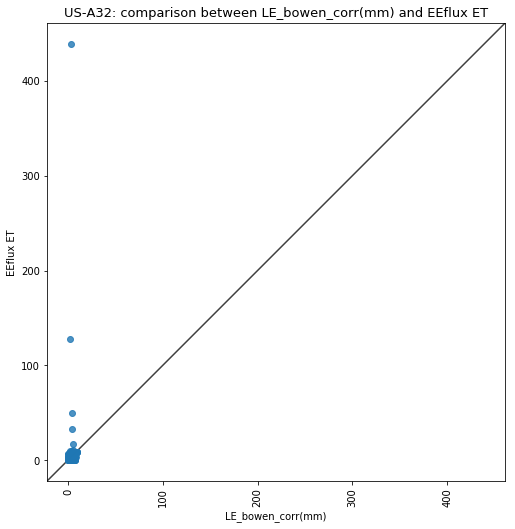

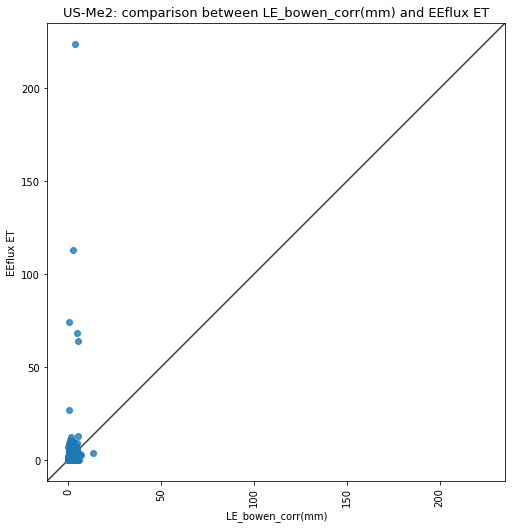

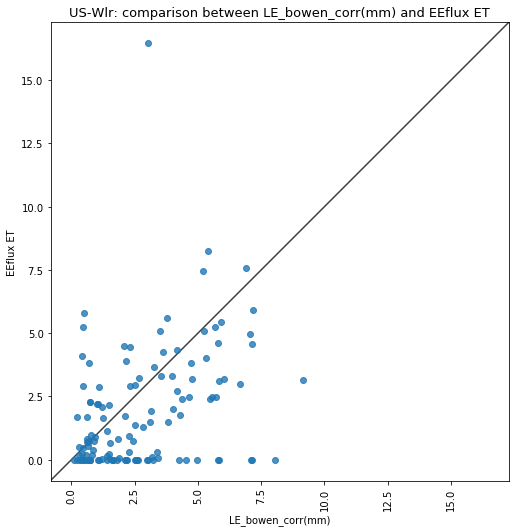

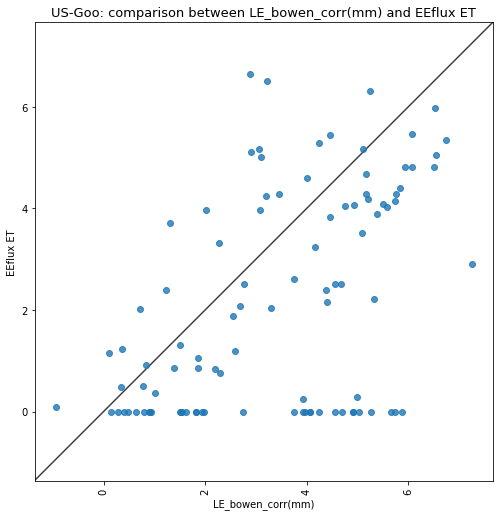

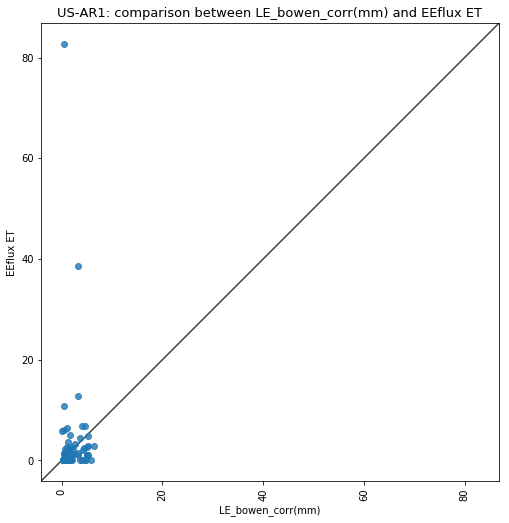

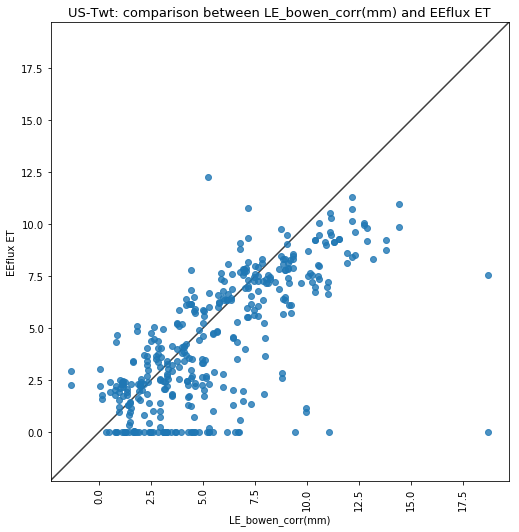

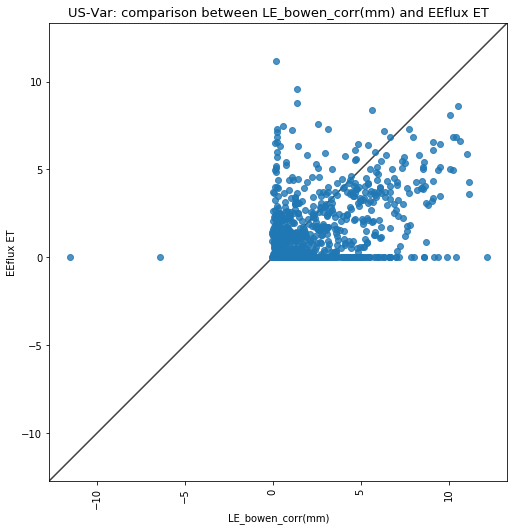

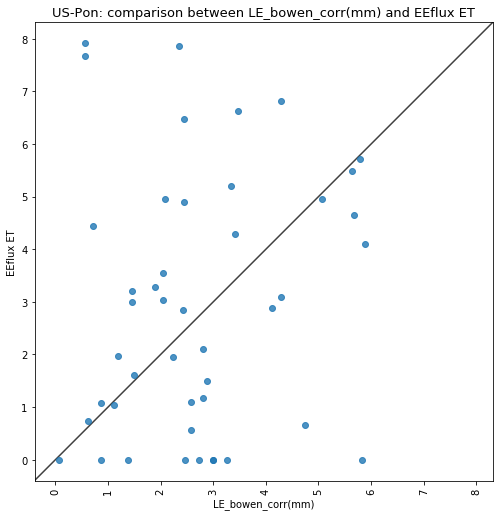

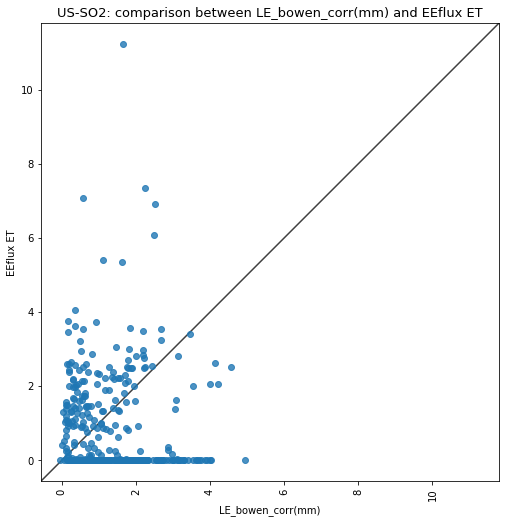

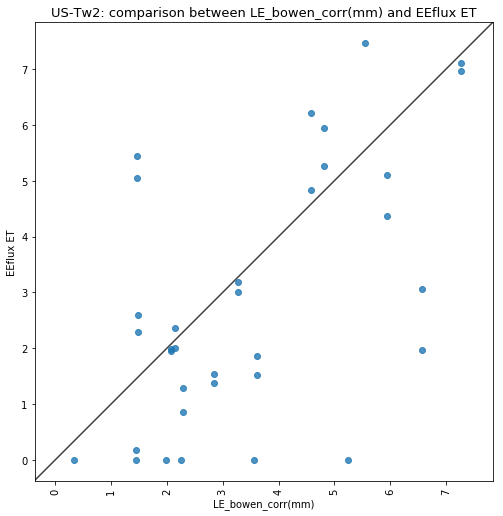

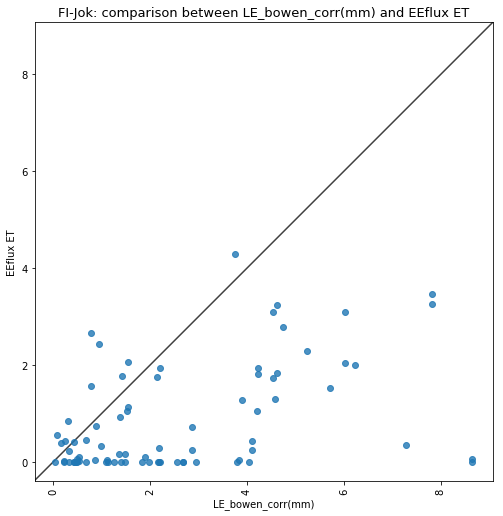

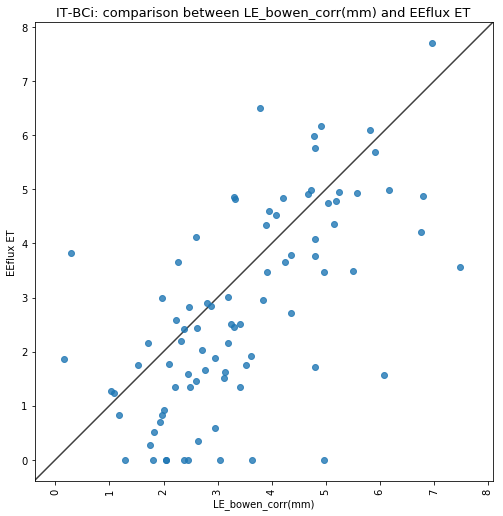

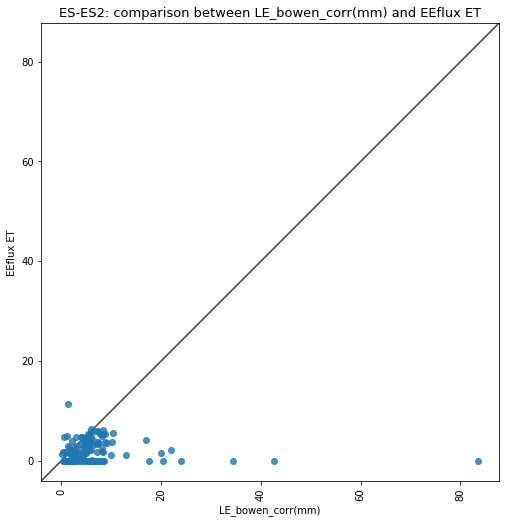

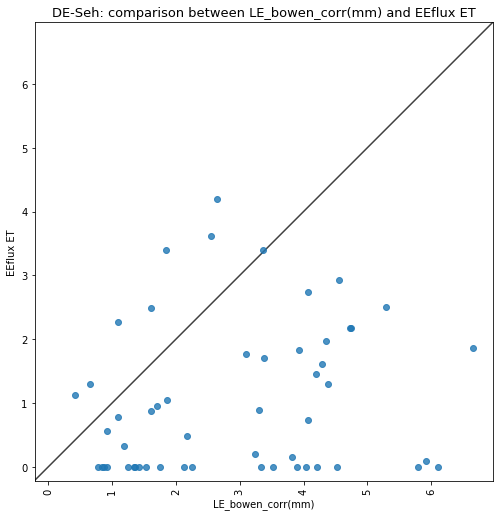

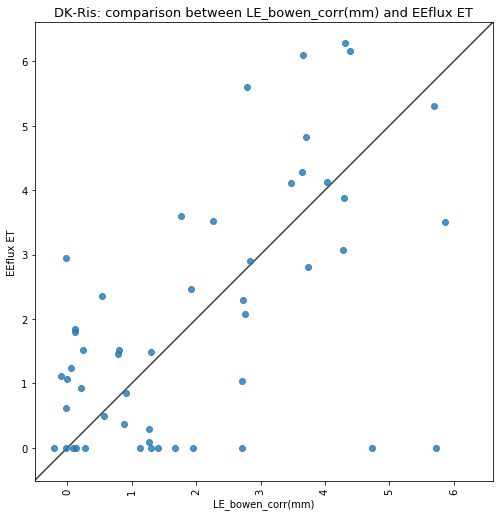

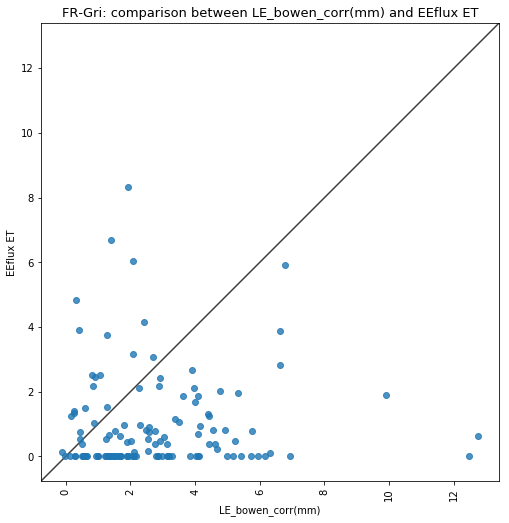

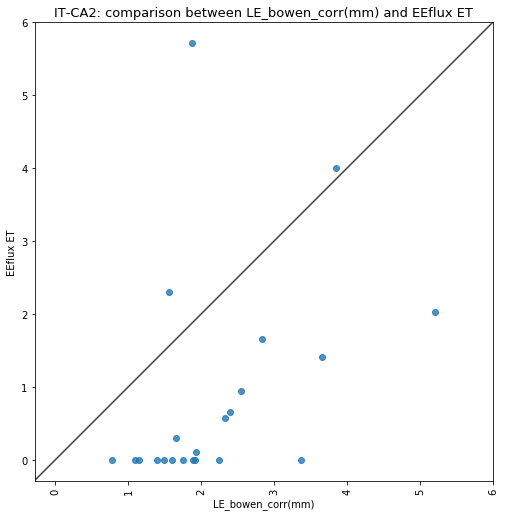

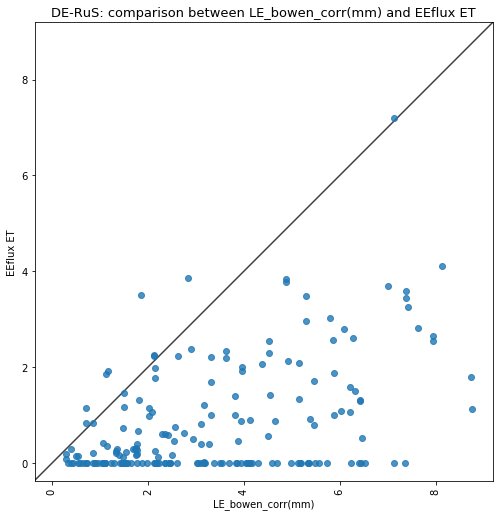

   Site Id         True Value Predicted Value  True Average Value        R2  \
0   US-A32  LE_bowen_corr(mm)       EEflux ET            3.718651   -271.75   
1   US-Me2  LE_bowen_corr(mm)       EEflux ET            2.153386    -89.84   
2   US-Wlr  LE_bowen_corr(mm)       EEflux ET            2.765499     -1.07   
3   US-Kon  LE_bowen_corr(mm)       EEflux ET            2.949096    -26.50   
4   US-FR2  LE_bowen_corr(mm)       EEflux ET            3.714870     -1.75   
5   US-Goo  LE_bowen_corr(mm)       EEflux ET            3.166851     -1.67   
6   US-SP2  LE_bowen_corr(mm)       EEflux ET            2.872752     -1.51   
7   US-AR1  LE_bowen_corr(mm)       EEflux ET            1.732170    -32.51   
8   US-Twt  LE_bowen_corr(mm)       EEflux ET            5.463167      0.18   
9   US-Ced  LE_bowen_corr(mm)       EEflux ET            2.111087   -247.97   
10  US-Tw3  LE_bowen_corr(mm)       EEflux ET            3.963791      0.09   
11  US-A74  LE_bowen_corr(mm)       EEflux ET       

In [5]:
full_path = os.path.join("/Users/saraawad/Desktop/", "Joint/Manual_Joint.csv")
tower_column = "LE_bowen_corr(mm)"
eeflux_column = "EEflux ET"
extra_column = ""
          
am_eg = ErrorGraph(full_path, tower_column, eeflux_column, extra_column, "", True)
df = am_eg.read_data()
df.head()
am_eg.prepare_data(df)

## Plot ETo Grass Reference ET versus EEflux ETo

ErrorGraph Initializer


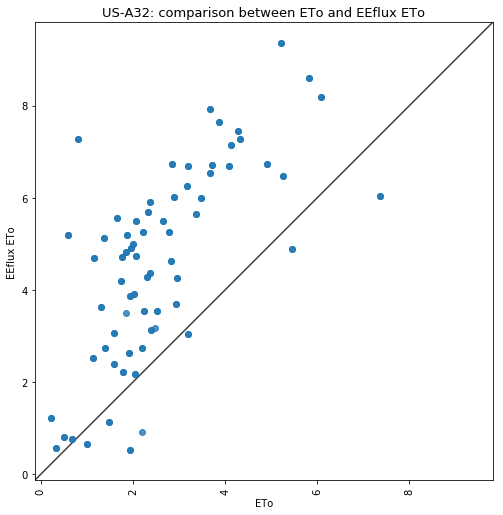

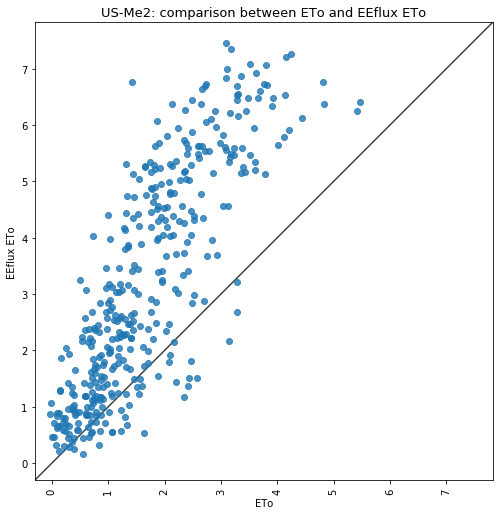

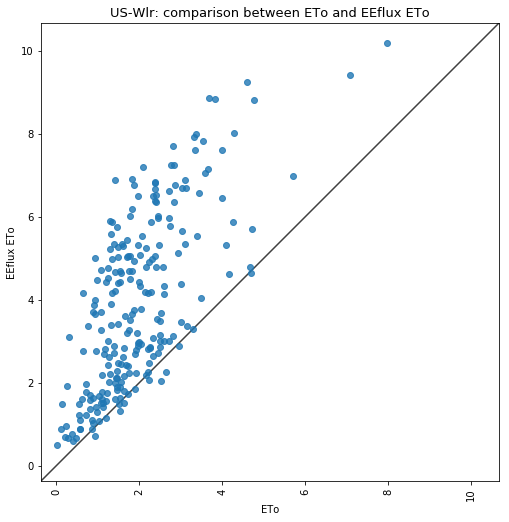

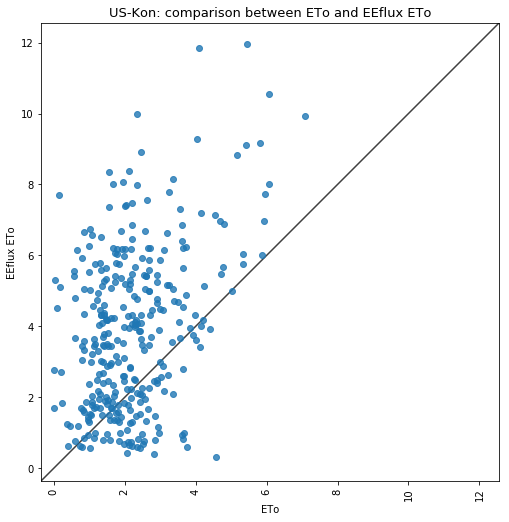

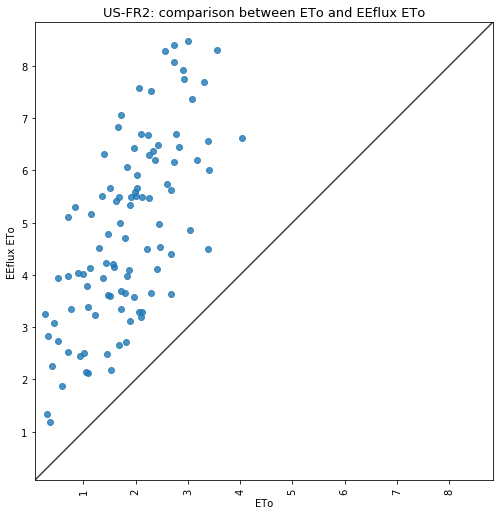

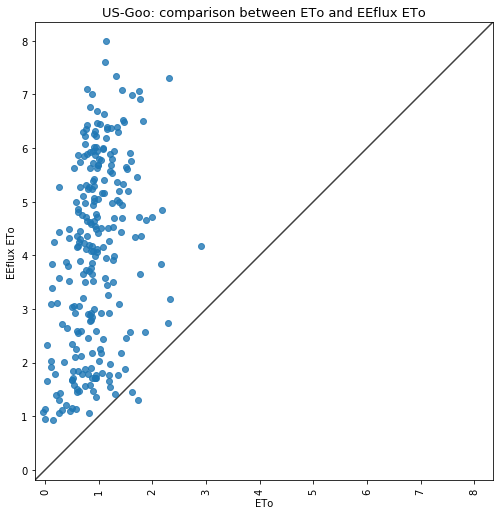

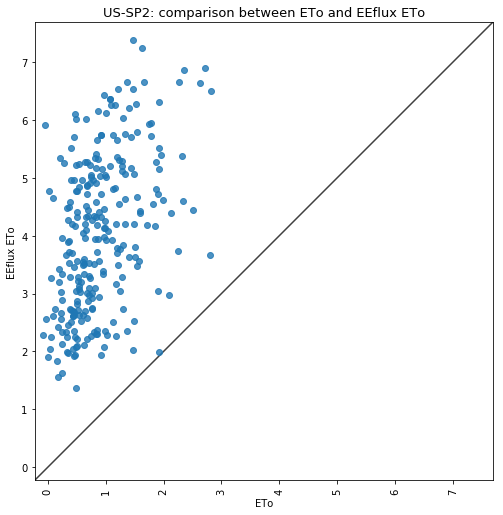

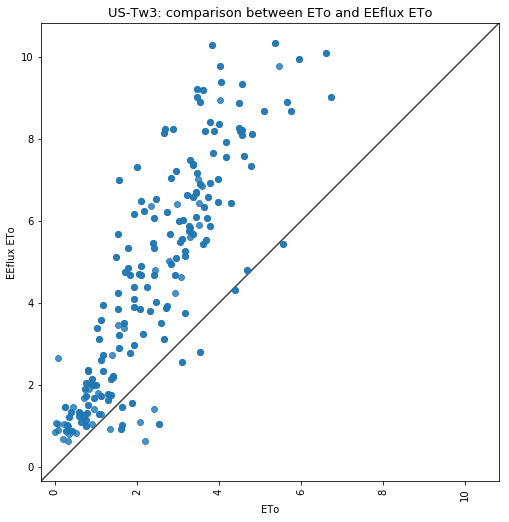

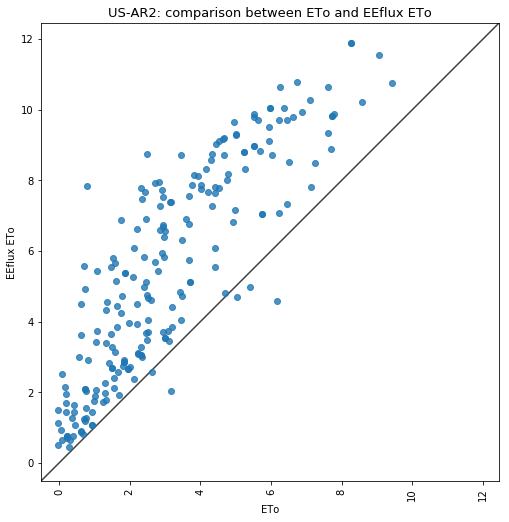

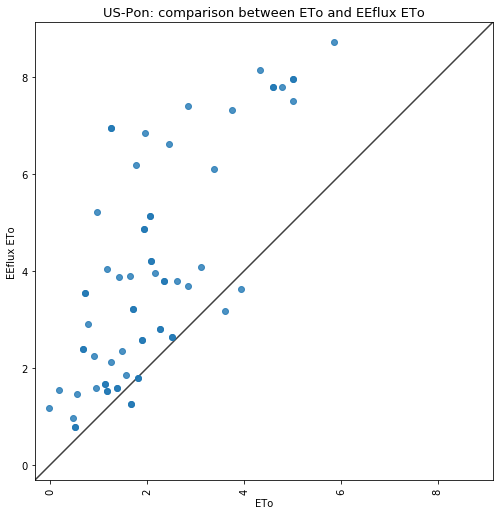

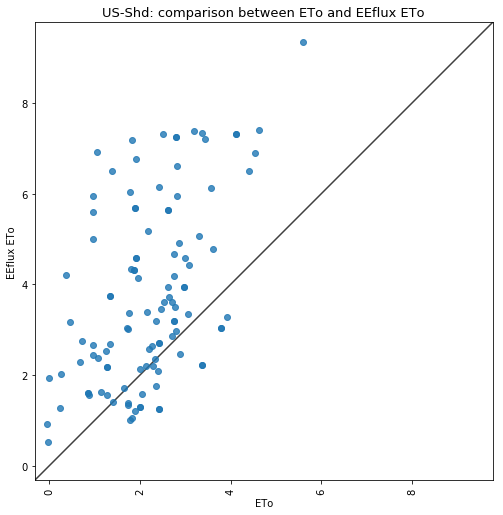

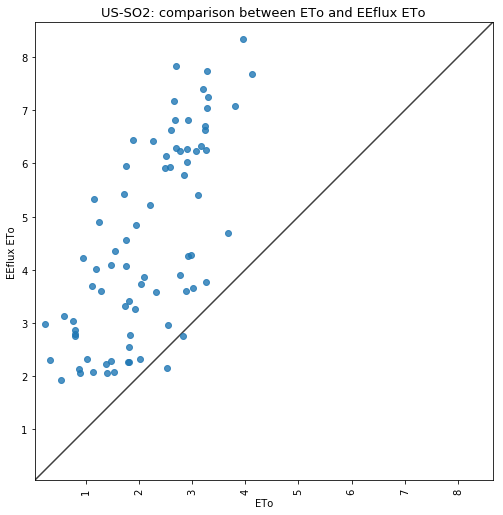

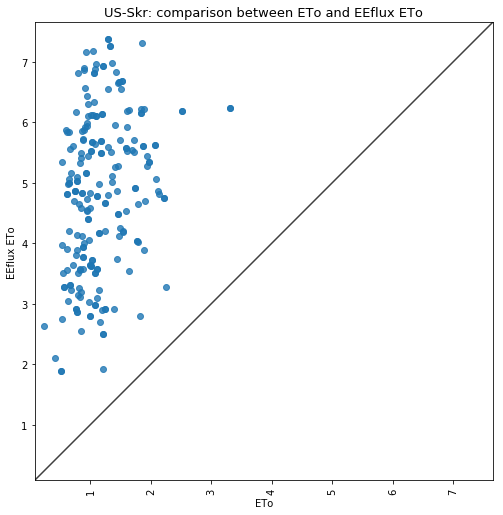

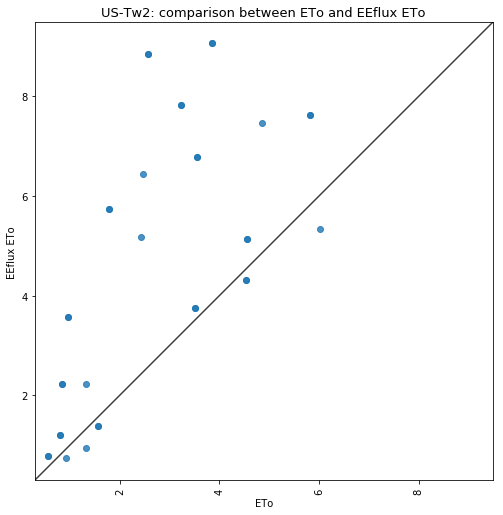

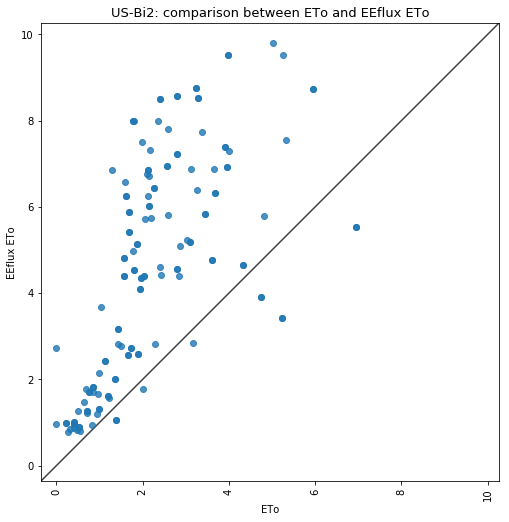

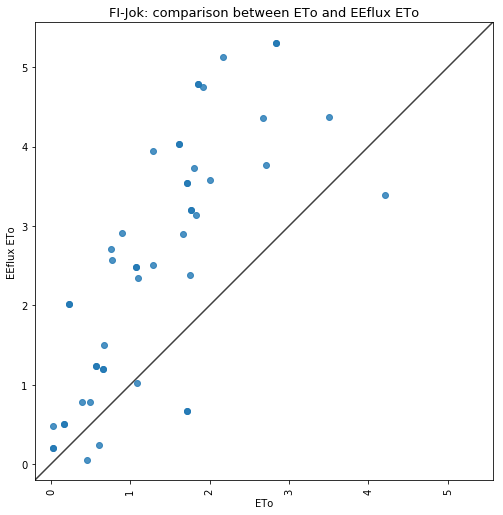

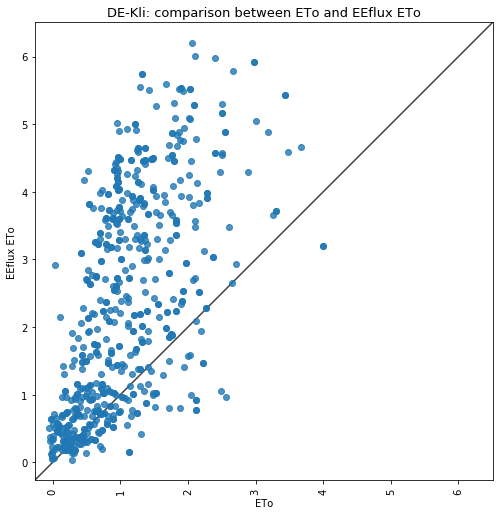

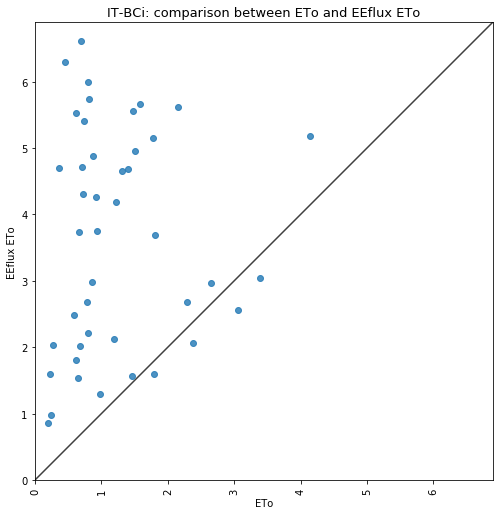

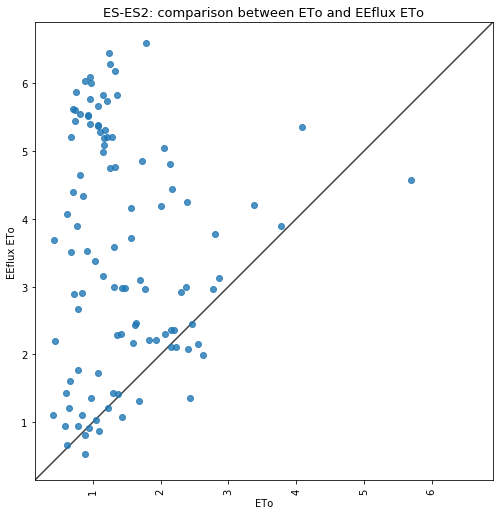

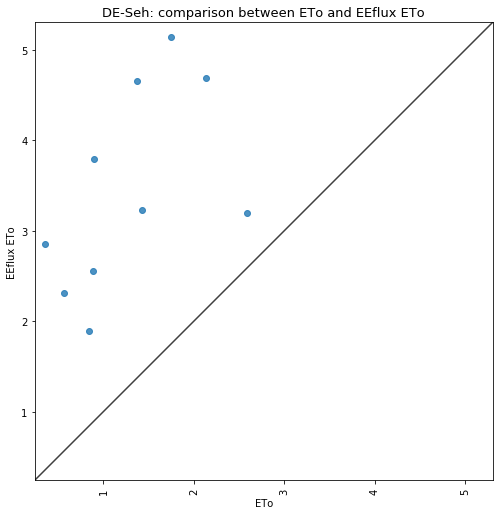

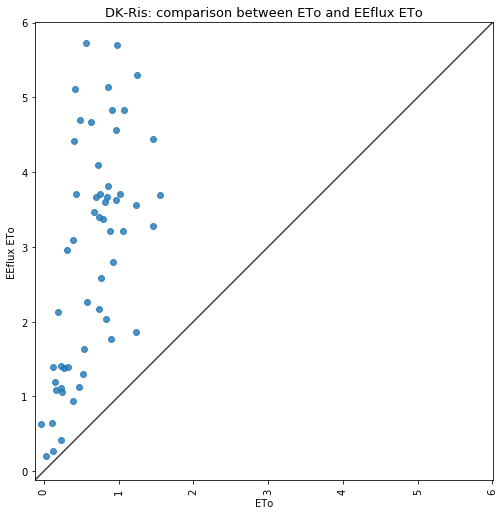

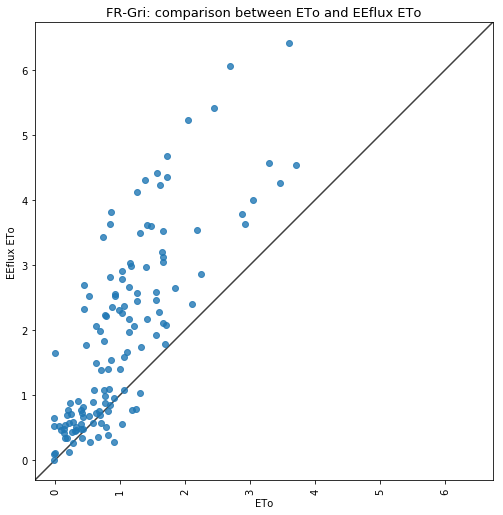

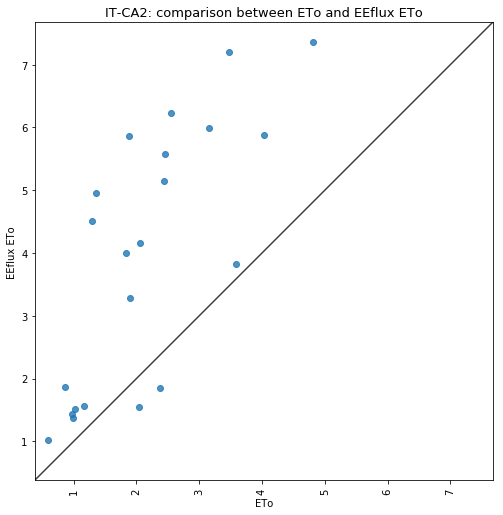

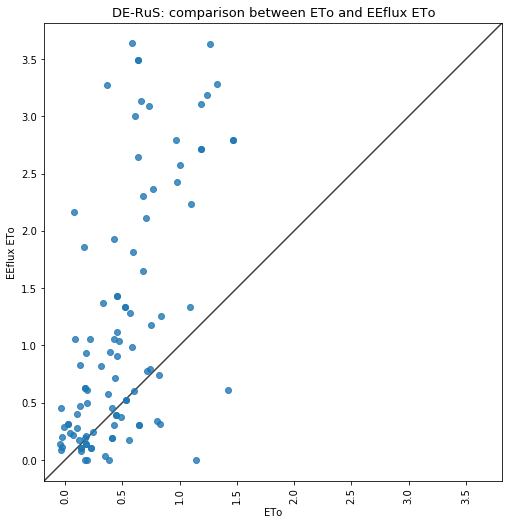

   Site Id True Value Predicted Value  True Average Value     R2  \
0   US-A32        ETo      EEflux ETo        2.608961e+00  -2.17   
1   US-Me2        ETo      EEflux ETo        1.663468e+00  -2.37   
2   US-Wlr        ETo      EEflux ETo        1.958933e+00  -3.91   
3   US-Kon        ETo      EEflux ETo        2.209314e+00  -3.73   
4   US-FR2        ETo      EEflux ETo        1.850576e+00 -14.37   
5   US-Goo        ETo      EEflux ETo        9.372156e-01 -56.85   
6   US-SP2        ETo      EEflux ETo        9.018480e-01 -32.94   
7   US-AR1        ETo      EEflux ETo        2.612426e+00  -1.47   
8   US-Twt        ETo      EEflux ETo        2.330322e+00  -3.67   
9   US-Ced        ETo      EEflux ETo        1.174430e+00 -22.03   
10  US-Tw3        ETo      EEflux ETo        2.509378e+00  -2.79   
11  US-A74        ETo      EEflux ETo        2.590439e+00  -2.93   
12  US-Var        ETo      EEflux ETo        1.419823e+00 -13.25   
13  US-Me6        ETo      EEflux ETo        8.7

In [7]:
full_path = os.path.join("/Users/saraawad/Desktop/", "Joint/Manual_Joint.csv")
tower_column = "ETo"
eeflux_column = "EEflux ETo"
extra_column = ""
          
am_eg = ErrorGraph(full_path, tower_column, eeflux_column, extra_column, "", True)
df = am_eg.read_data()
am_eg.prepare_data(df)

## Plot EToF versus EEflux EToF

ErrorGraph Initializer


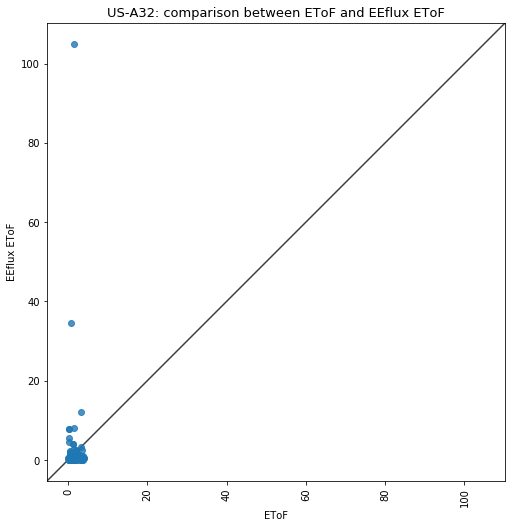

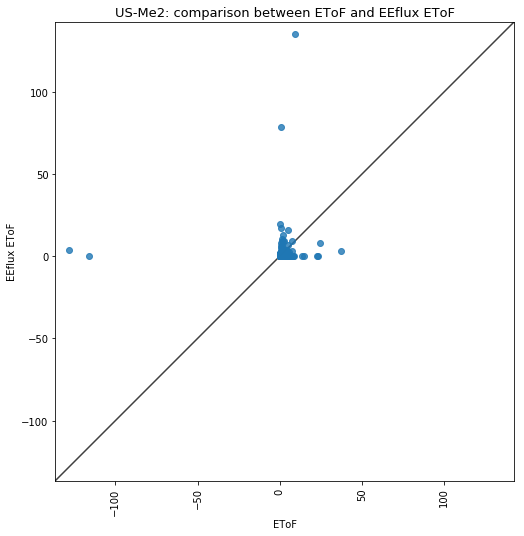

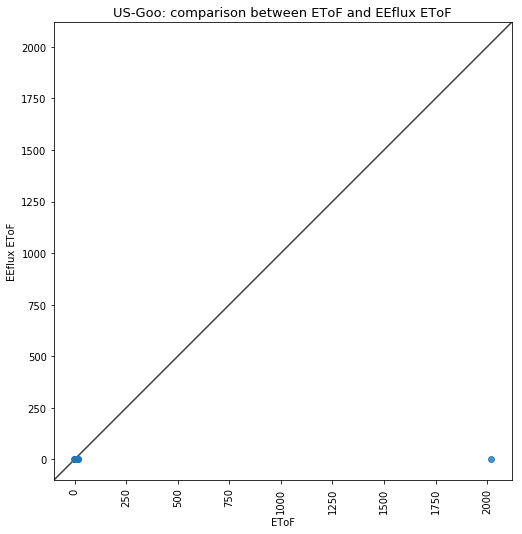

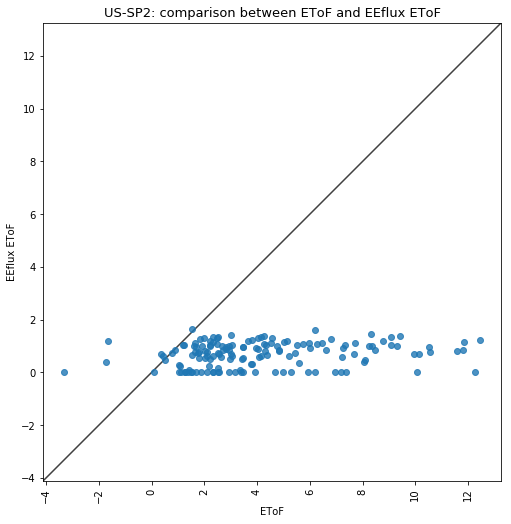

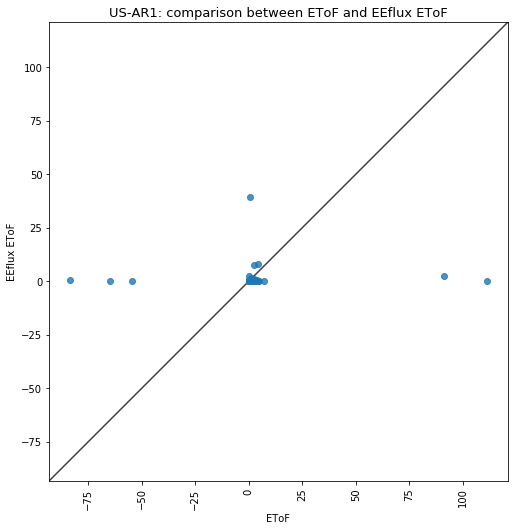

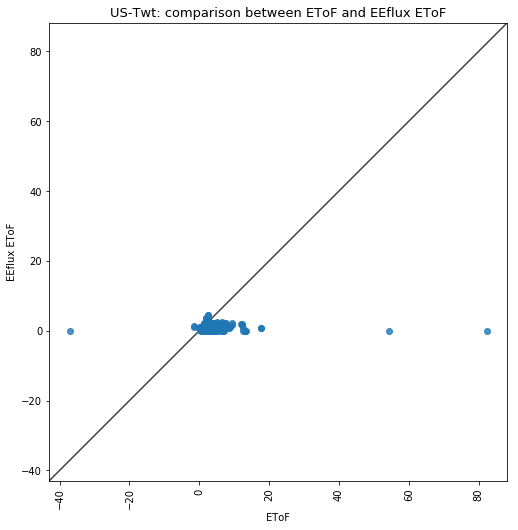

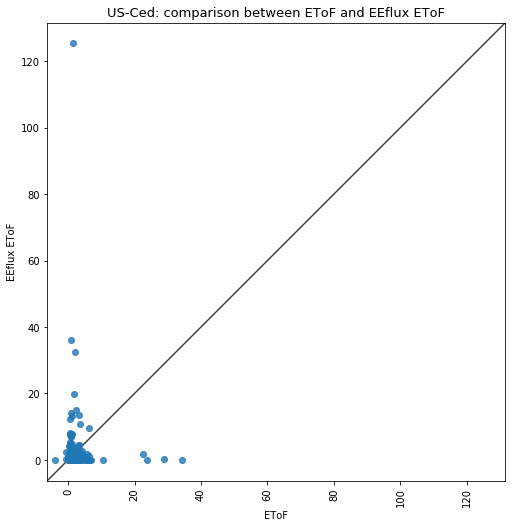

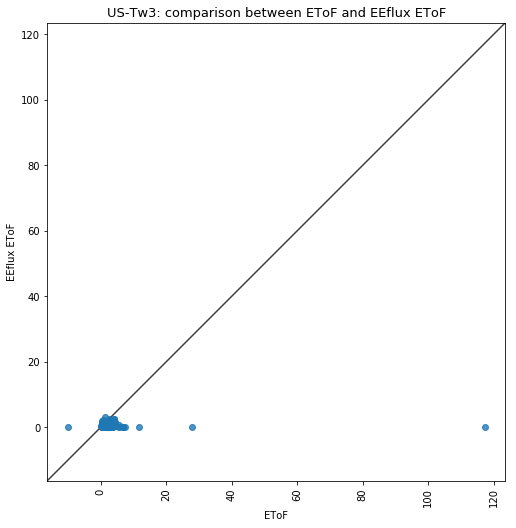

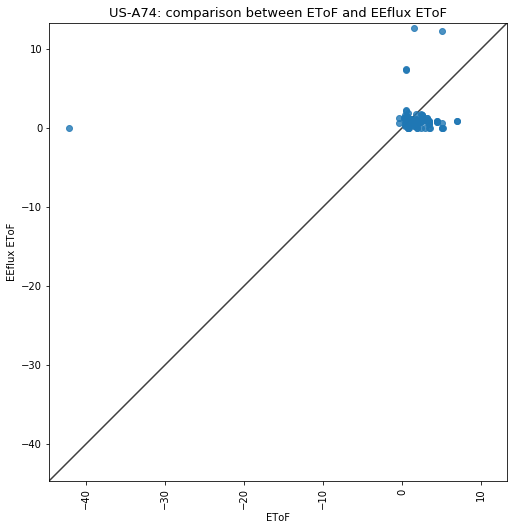

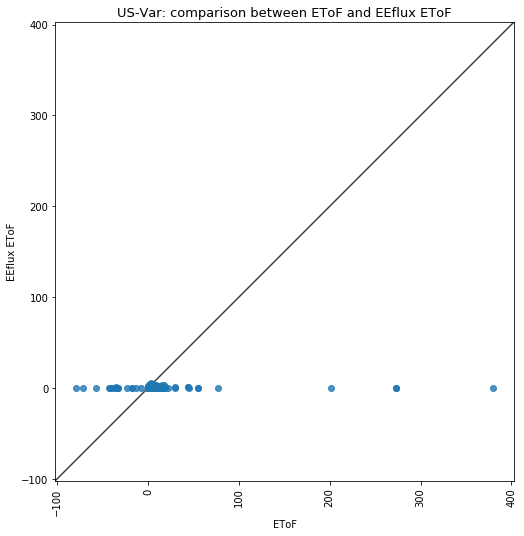

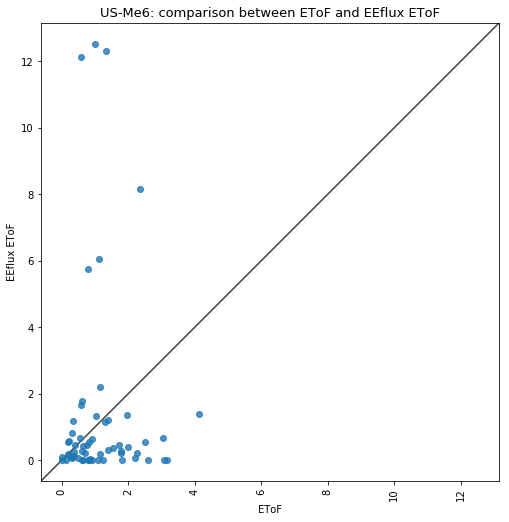

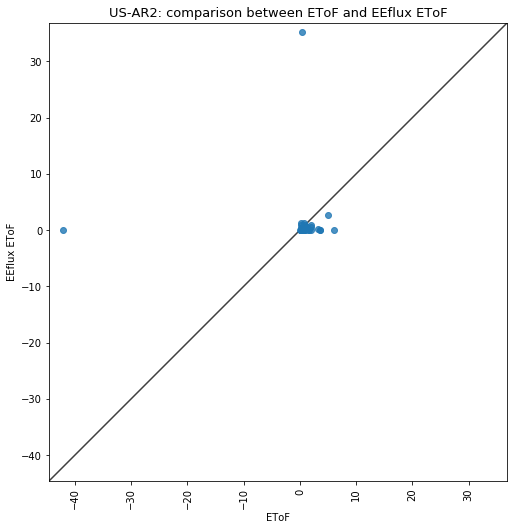

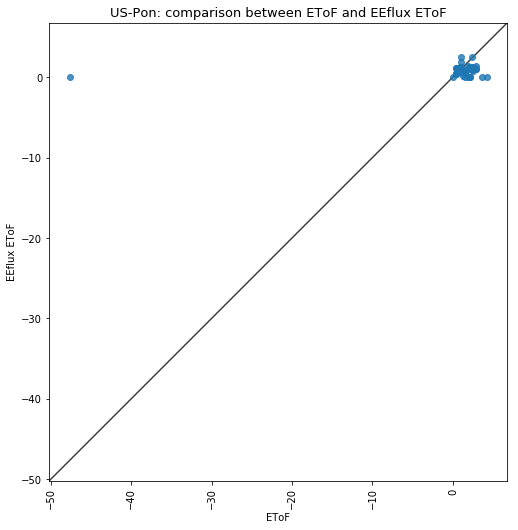

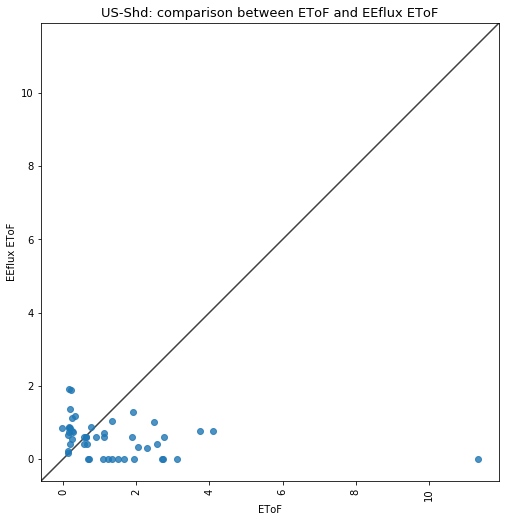

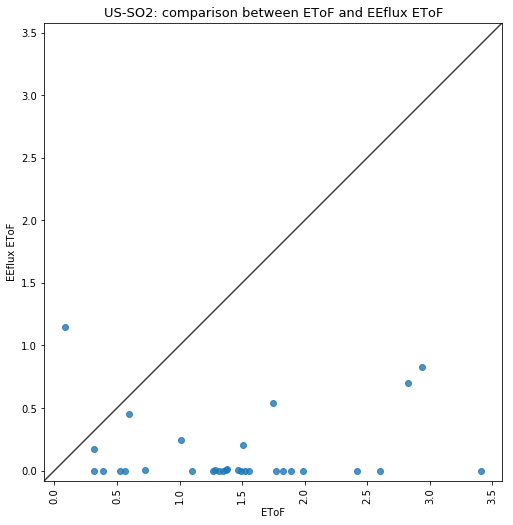

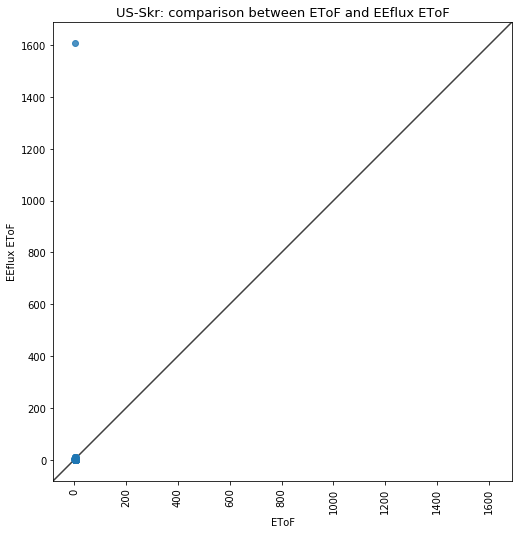

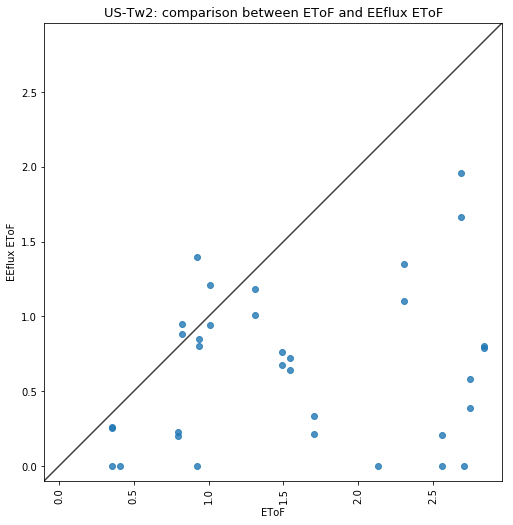

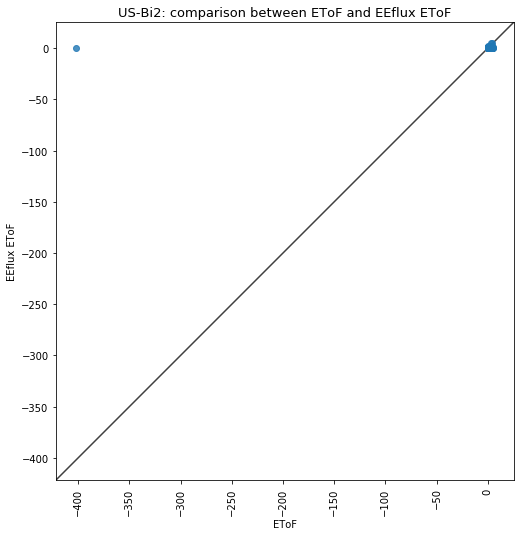

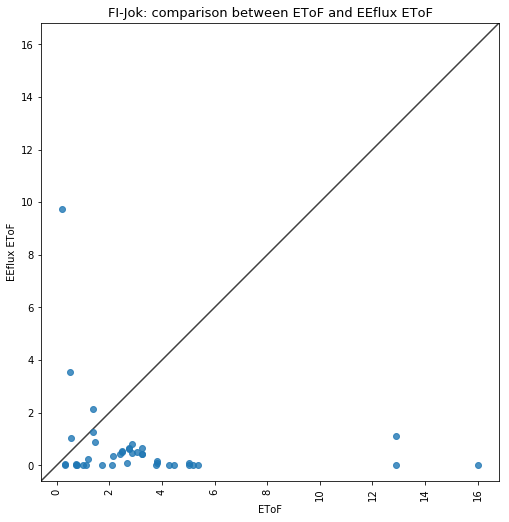

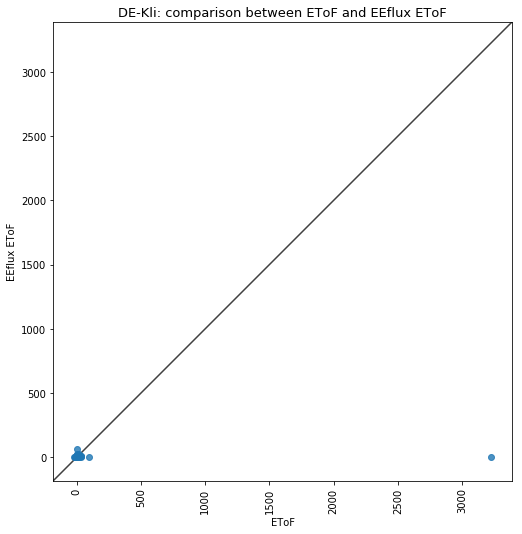

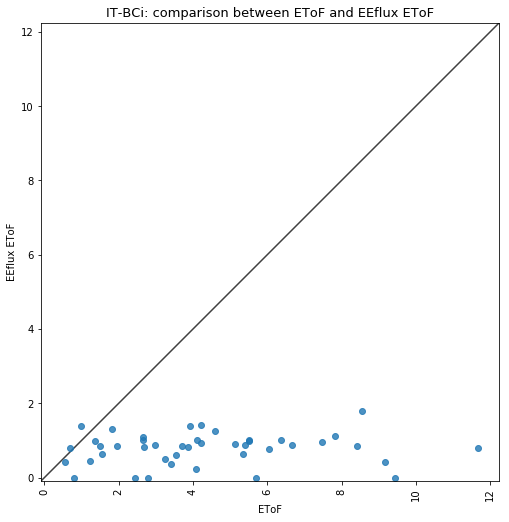

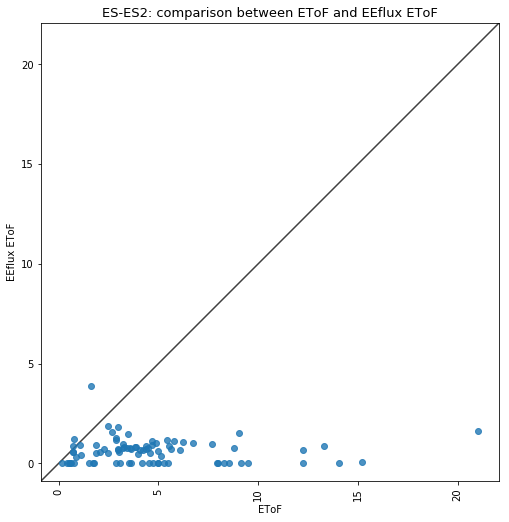

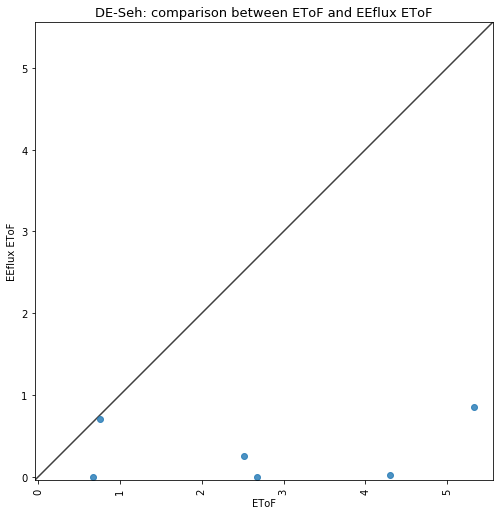

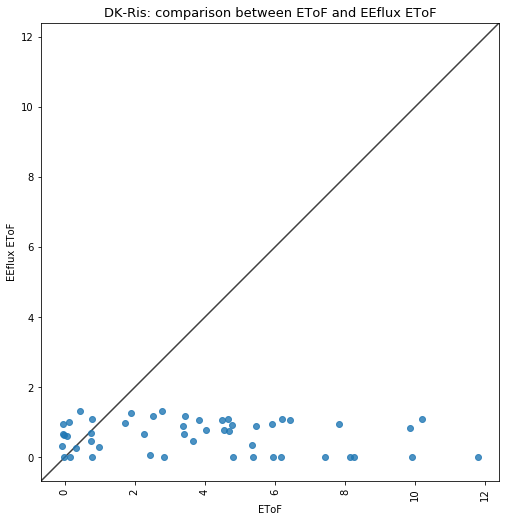

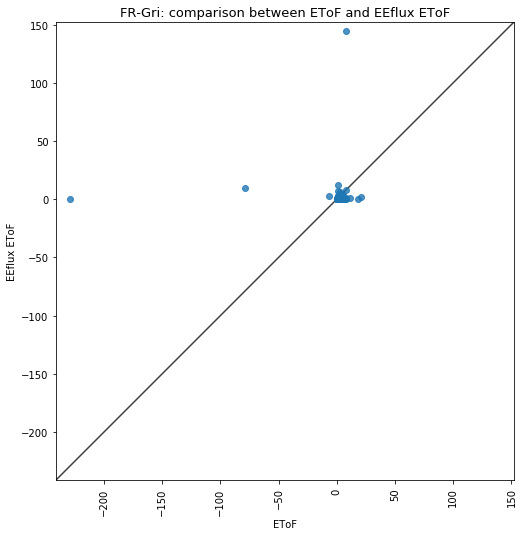

   Site Id True Value Predicted Value  True Average Value       R2    RMSE  \
0   US-A32       EToF     EEflux EToF            1.590790   -91.39    9.58   
1   US-Me2       EToF     EEflux EToF            0.658934    -0.20   18.92   
2   US-Wlr       EToF     EEflux EToF            1.771527    -0.91    2.33   
3   US-Kon       EToF     EEflux EToF            0.080907    -0.00   47.58   
4   US-FR2       EToF     EEflux EToF            2.452481    -1.26    3.15   
5   US-Goo       EToF     EEflux EToF           12.422194    -0.01  127.24   
6   US-SP2       EToF     EEflux EToF            4.122782    -0.37    7.12   
7   US-AR1       EToF     EEflux EToF            0.713630    -0.03   17.66   
8   US-Twt       EToF     EEflux EToF            3.241509    -0.20    6.09   
9   US-Ced       EToF     EEflux EToF            2.019450    -5.12    6.51   
10  US-Tw3       EToF     EEflux EToF            2.218110    -0.08    6.64   
11  US-A74       EToF     EEflux EToF            1.461818    -0.

In [8]:
full_path = os.path.join("/Users/saraawad/Desktop/", "Joint/Manual_Joint.csv")
tower_column = "EToF"
eeflux_column = "EEflux EToF"
extra_column = ""
          
am_eg = ErrorGraph(full_path, tower_column, eeflux_column, extra_column, "", True)
df = am_eg.read_data()
df.head()
am_eg.prepare_data(df)

## Plot ETr Alfafa Reference ET versus EEflux ETr

ErrorGraph Initializer


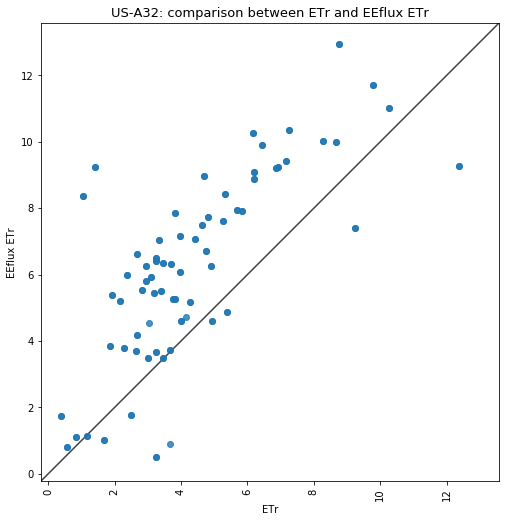

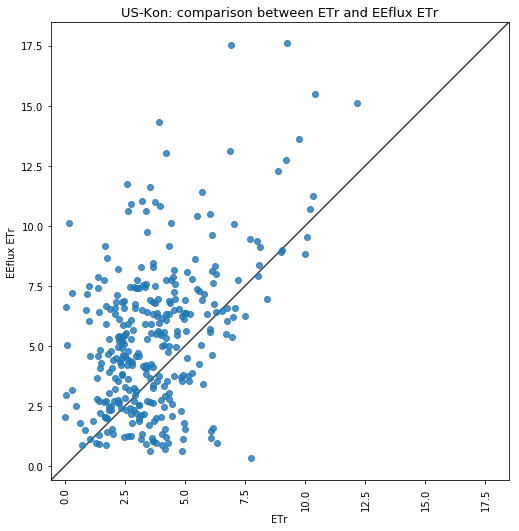

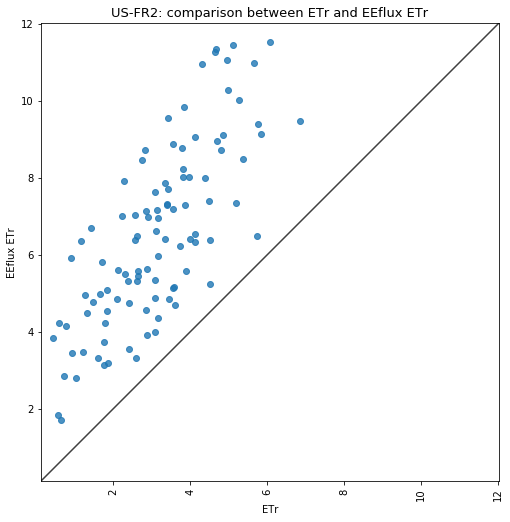

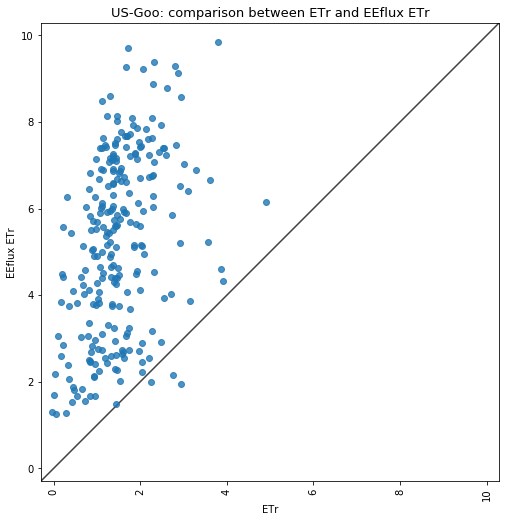

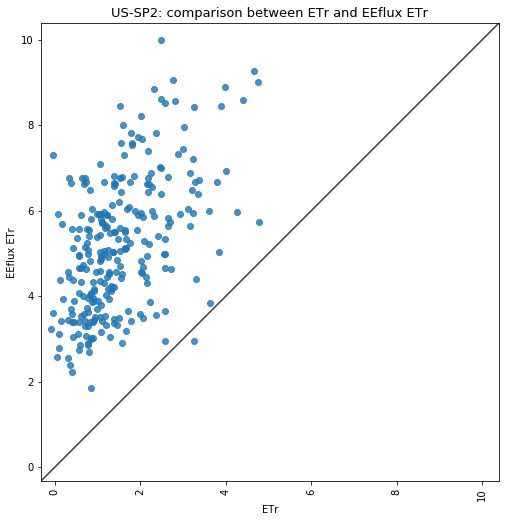

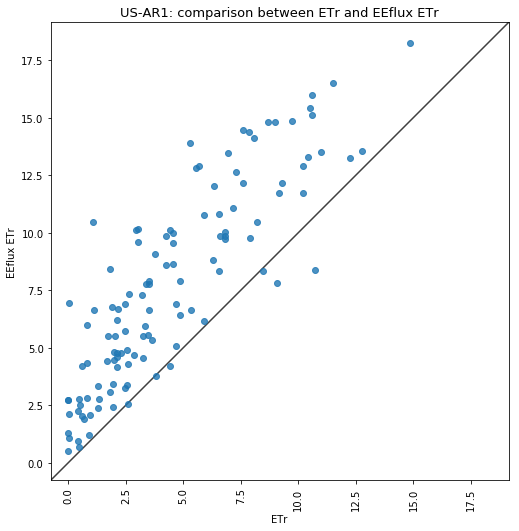

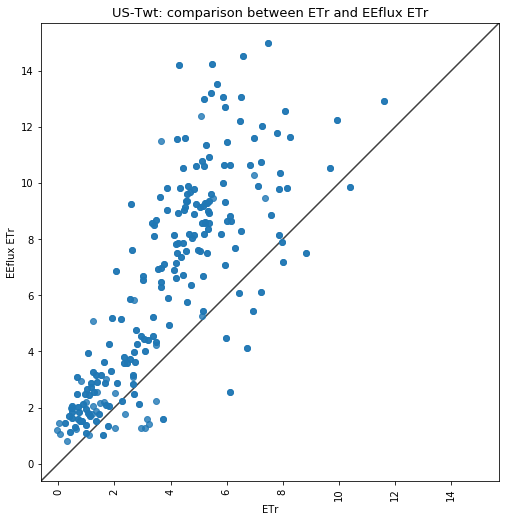

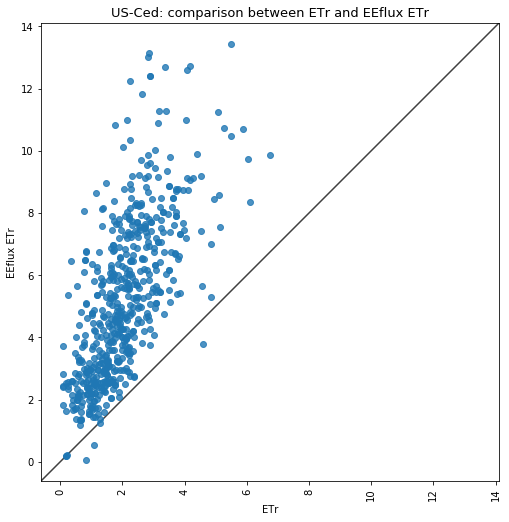

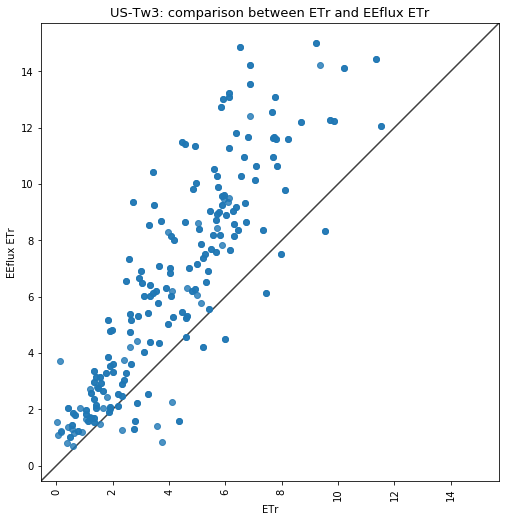

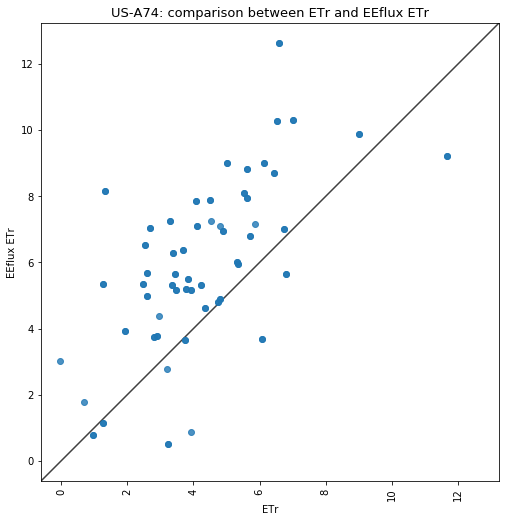

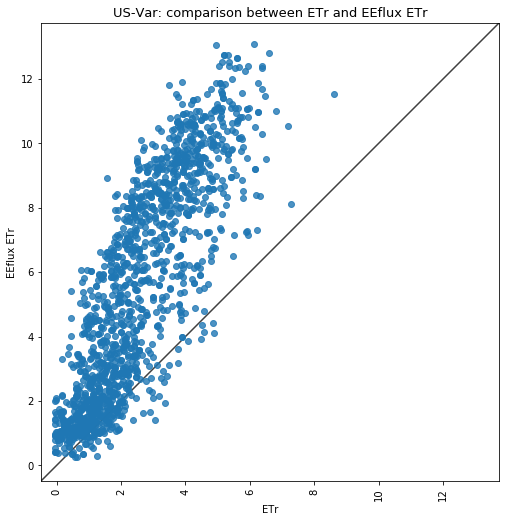

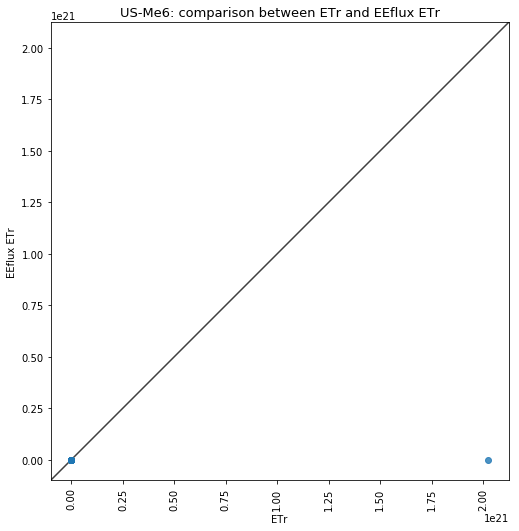

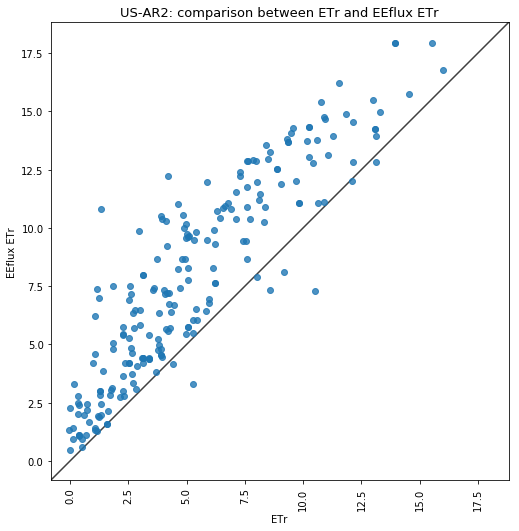

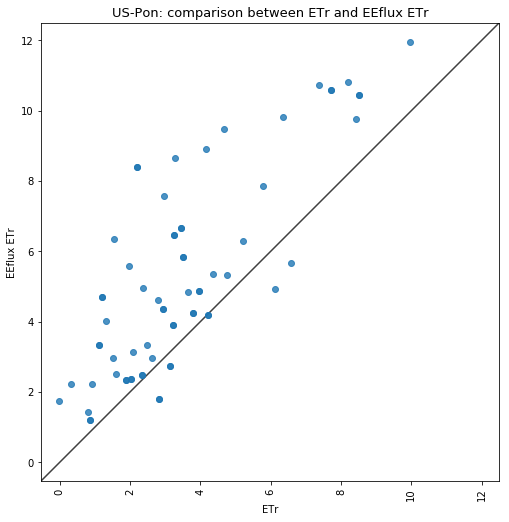

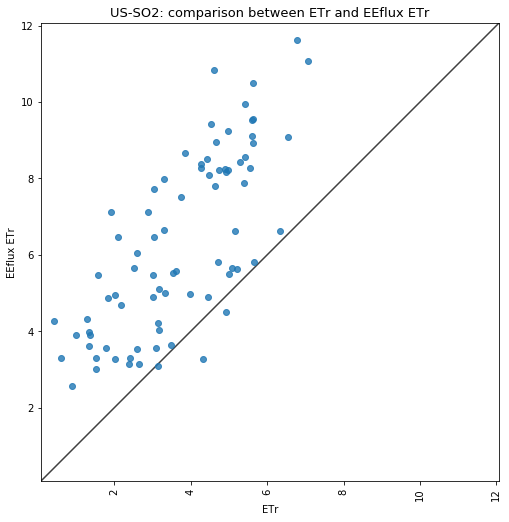

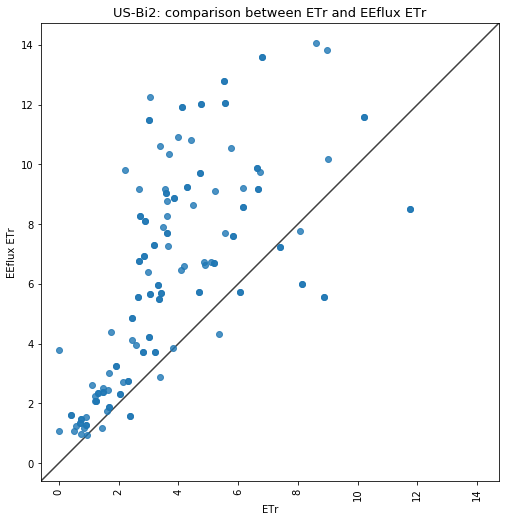

   Site Id True Value Predicted Value  True Average Value     R2  \
0   US-A32        ETr      EEflux ETr        4.360761e+00  -0.27   
1   US-Me2        ETr      EEflux ETr        2.833651e+00  -0.11   
2   US-Wlr        ETr      EEflux ETr        3.316390e+00  -0.99   
3   US-Kon        ETr      EEflux ETr        3.737245e+00  -1.32   
4   US-FR2        ETr      EEflux ETr        3.132082e+00  -5.86   
5   US-Goo        ETr      EEflux ETr        1.507119e+00 -28.59   
6   US-SP2        ETr      EEflux ETr        1.525094e+00 -14.94   
7   US-AR1        ETr      EEflux ETr        4.445549e+00  -0.26   
8   US-Twt        ETr      EEflux ETr        3.956327e+00  -1.23   
9   US-Ced        ETr      EEflux ETr        2.010526e+00 -11.01   
10  US-Tw3        ETr      EEflux ETr        4.272252e+00  -0.65   
11  US-A74        ETr      EEflux ETr        4.311944e+00  -0.72   
12  US-Var        ETr      EEflux ETr        2.536727e+00  -4.76   
13  US-Me6        ETr      EEflux ETr        1.4

In [12]:
full_path = os.path.join("/Users/saraawad/Desktop/", "Joint/Manual_Joint.csv")
tower_column = "ETr"
eeflux_column = "EEflux ETr"
extra_column = ""
    
am_eg = ErrorGraph(full_path, tower_column, eeflux_column, extra_column, "", True)
df = am_eg.read_data()

#Remove Euroflux Sites since for now we do not have ETr for them in EEflux
df = df[df["Site Id"].str.startswith("US")]
am_eg.prepare_data(df)

## Plot ETrF versus EEflux ETrF

ErrorGraph Initializer


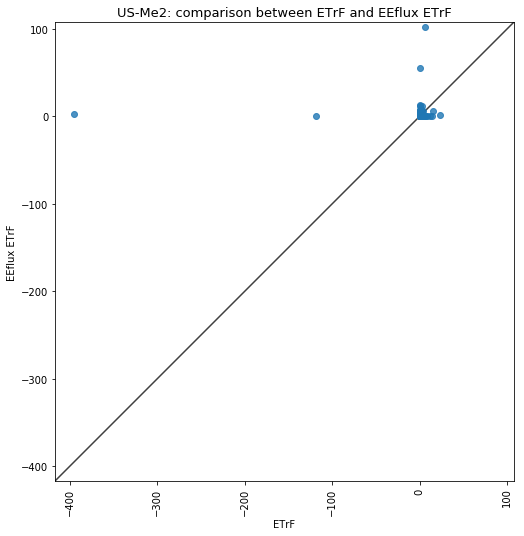

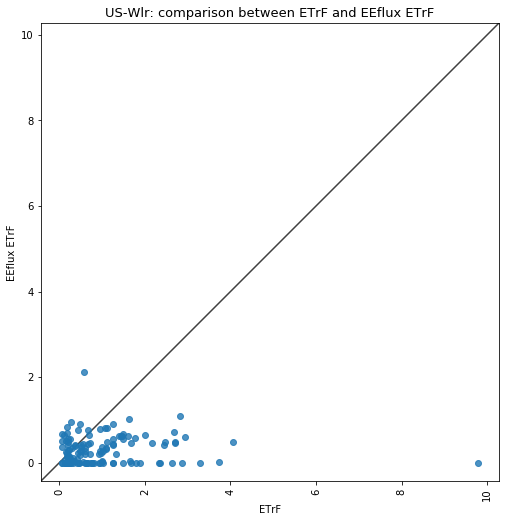

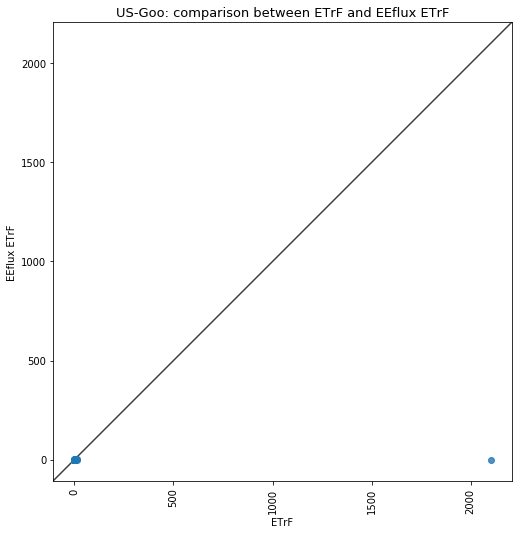

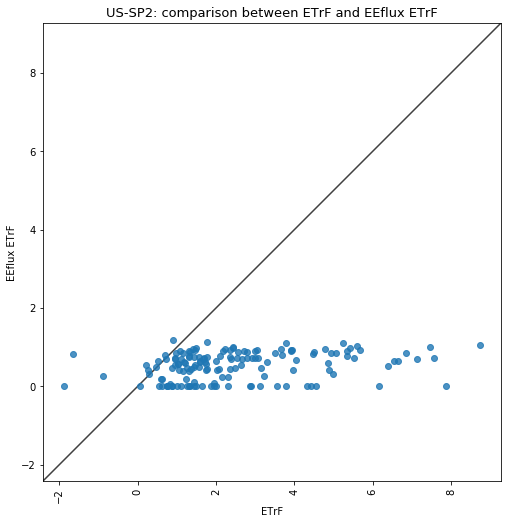

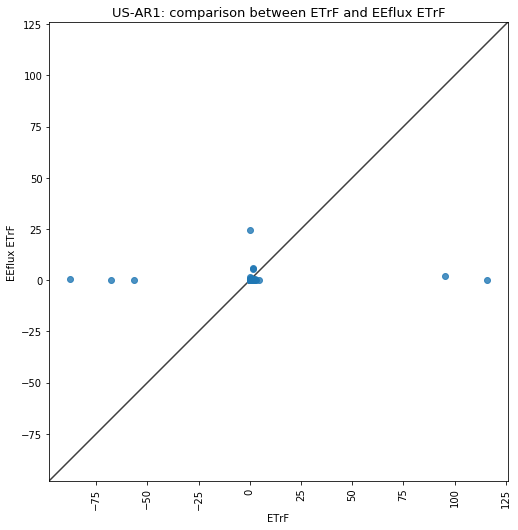

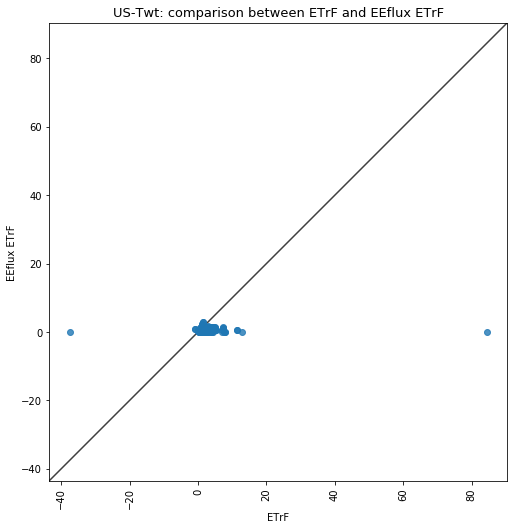

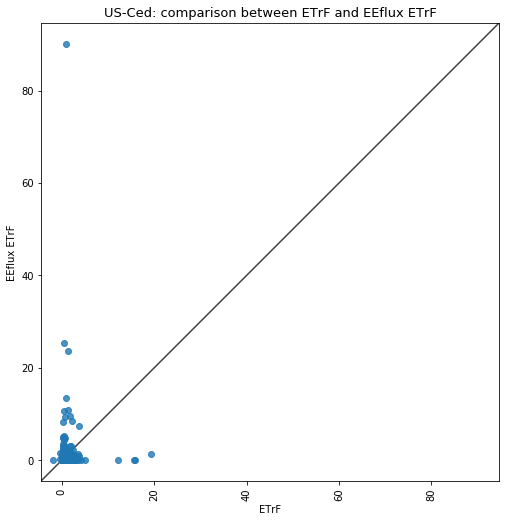

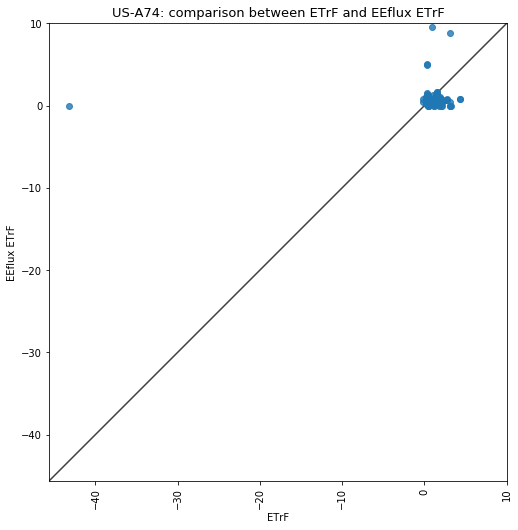

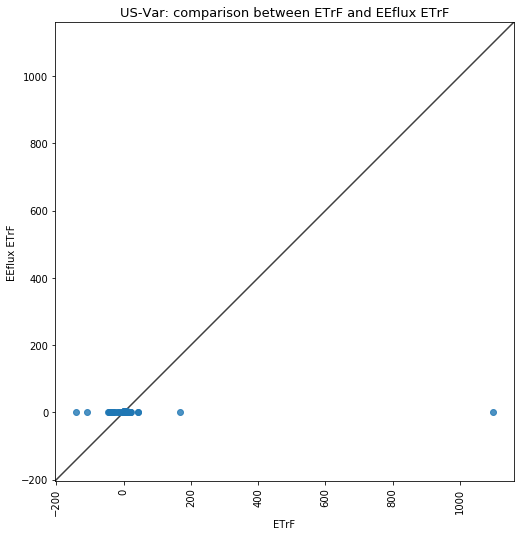

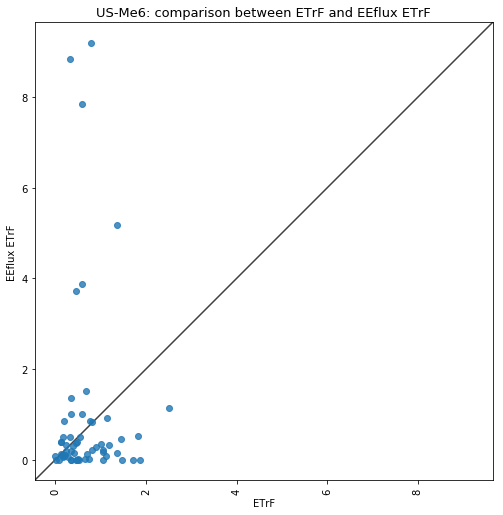

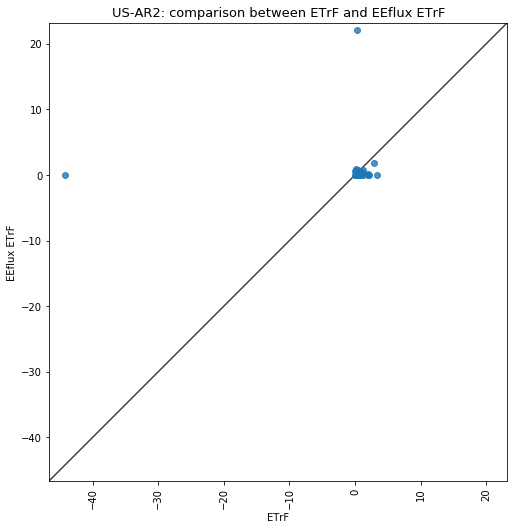

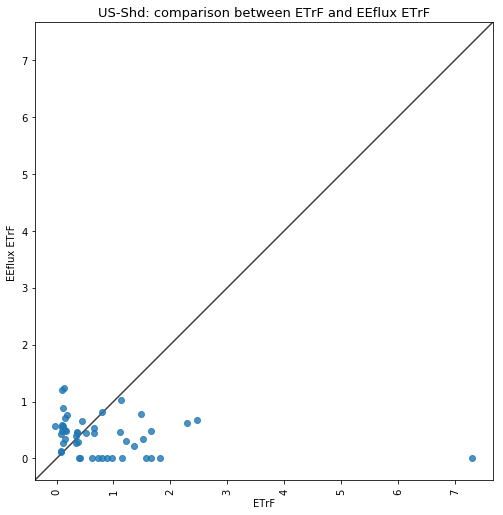

   Site Id True Value Predicted Value  True Average Value       R2    RMSE  \
0   US-A32       ETrF     EEflux ETrF            0.955685  -142.86    7.26   
1   US-Me2       ETrF     EEflux ETrF            0.324103    -0.07   23.60   
2   US-Wlr       ETrF     EEflux ETrF            1.059576    -0.77    1.43   
3   US-Kon       ETrF     EEflux ETrF           -0.697151    -0.00   49.64   
4   US-FR2       ETrF     EEflux ETrF            1.455894    -1.21    1.87   
5   US-Goo       ETrF     EEflux ETrF           11.293326    -0.01  132.42   
6   US-SP2       ETrF     EEflux ETrF            2.510214    -0.60    3.59   
7   US-AR1       ETrF     EEflux ETrF           -0.050090    -0.01   19.16   
8   US-Twt       ETrF     EEflux ETrF            1.909009    -0.09    4.93   
9   US-Ced       ETrF     EEflux ETrF            1.170692    -7.82    4.48   
10  US-Tw3       ETrF     EEflux ETrF            1.462300    -0.03    6.63   
11  US-A74       ETrF     EEflux ETrF            0.713181    -0.

In [13]:
full_path = os.path.join("/Users/saraawad/Desktop/", "Joint/Manual_Joint.csv")
tower_column = "ETrF"
eeflux_column = "EEflux ETrF"
extra_column = ""
          
am_eg = ErrorGraph(full_path, tower_column, eeflux_column, extra_column, "", True)
df = am_eg.read_data()

#Remove Euroflux Sites since for now we do not have ETrF for them in EEflux
df = df[df["Site Id"].str.startswith("US")]
df.head()
am_eg.prepare_data(df)